Below is an implementation of an autoencoder written in PyTorch. We apply it to the MNIST dataset.

In [1]:
from google.colab import drive
drive.mount('/content/drive')
base_dir = '/content/drive/My Drive/gary_class_project/'
save_dir = base_dir + 'results'

Mounted at /content/drive


In [ ]:
!pip install wandb -q
!pip install neurora -q
!wandb login
# wandb api key 18a861e71f78135d23eb672c08922edbfcb8d364

wandb: Currently logged in as: siddsuresh97 (use `wandb login --relogin` to force relogin)


In [4]:
import torch; torch.manual_seed(0)
# import wandb
import os
import torch.nn as nn
import torch.nn.functional as F
import torch.utils
import torch.distributions
import torchvision
from tqdm import tqdm
import random
import numpy as np
import matplotlib.pyplot as plt; plt.rcParams['figure.dpi'] = 200
# from neurora.rdm_corr import rdm_correlation_spearman

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Conv Autoencoder

## Initialising global variables

In [ ]:
num_classes = 11 # Number of unique class labels in the dataset
latent_dims = 2
epochs = 20
label_training_ratio = 0.8

## Setting up the network

In [ ]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim, num_classes):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_labels_lin = nn.Linear(num_classes, num_classes//2)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32 + num_classes//2, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
        
    def forward(self, x, y):
        img_features = self.encoder_cnn(x)
        img_features = self.flatten(img_features)
        label_features = self.encoder_labels_lin(y)
        combined = torch.cat((img_features, label_features), dim = -1)
        out = self.encoder_lin(combined)
        return out

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, num_classes):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32 + (num_classes)//2),
            nn.ReLU(True)
        )
        self.decoder_labels_lin = nn.Linear((num_classes)//2, num_classes)
        
        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        img_features = x[:, :-(num_classes//2)]
        label_features = x[:, -(num_classes//2):]
        img_features = self.unflatten(img_features)
        img_features = self.decoder_conv(img_features)
        img = torch.sigmoid(img_features)
        label = self.decoder_labels_lin(label_features)
        return img, label

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # self.gamma = nn.Parameter(torch.tensor([.5]))
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, img, pred_img, label, pred_label):
        mse_loss_img = ((img - pred_img)**2).sum()
        mse_loss_label = self.cross_entropy(pred_label, label.float())
        # loss = mse_loss_img * torch.sigmoid(self.gamma) + \
              # mse_loss_label * (1 - torch.sigmoid(self.gamma))
        loss = mse_loss_img + mse_loss_label#*torch.sigmoid(self.gamma)
        return mse_loss_img, mse_loss_label, loss

class Autoencoder(nn.Module):
    def __init__(self, latent_dims, num_classes):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims, num_classes)
        self.decoder = Decoder(latent_dims, num_classes)
        self.custom_loss = CustomLoss()
        self.num_classes = num_classes
    
    def forward(self, x, y):
        z = self.encoder(x, y)
        return self.decoder(z)

    def test_epoch(self, test_data):
    # Set evaluation mode for encoder and decoder
        self.eval()
        with torch.no_grad(): # No need to track the gradients
            # Define the lists to store the outputs for each batch
            test_img_loss = []
            test_label_loss = []
            total_test_loss = []
            for image_batch, label_batch in test_data:
                total = 0
                correct = 0
                # Move tensor to the proper device
                image_batch = image_batch.to(device)
                label_batch = F.one_hot(label_batch, num_classes=self.num_classes)
                label_batch = label_batch.to(device)
                pred_img, pred_label = self.forward(image_batch, label_batch.float()) 
                # Append the network output and the original image to the lists
                img_loss, label_loss, total_loss = self.custom_loss(image_batch,
                                                                pred_img, 
                                                                label_batch, 
                                                                pred_label)
                total += y.size(0)
                correct += (torch.argmax(pred_label, dim = 1) == torch.argmax(label_batch, dim = 1)).sum().item()
                test_img_loss.append(img_loss.item())
                test_label_loss.append(label_loss.item())
                total_test_loss.append(total_loss.item())
        test_img_loss = sum(test_img_loss)/len(test_img_loss)
        test_label_loss = sum(test_label_loss)/len(test_label_loss)
        total_test_loss = sum(total_test_loss)/len(total_test_loss)
        test_accuracy = correct/total
        return test_img_loss, test_label_loss, total_test_loss, test_accuracy

    def train_epoch(self, train_data, optimizer, training_label_ratio):
        self.train()
        torch.manual_seed(0)
        train_img_loss = []
        train_label_loss = []
        train_loss = []
        correct = 0
        total = 0
        for image_batch, label_batch in train_data:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            num_training_examples = label_batch.shape[0]
            num_non_label_training_examples = num_training_examples*(1-training_label_ratio)
            non_label_training_idx = random.sample(range(num_training_examples),int(num_non_label_training_examples))
            label_batch[[non_label_training_idx]] = self.num_classes - 1
            label_batch = F.one_hot(label_batch, num_classes=self.num_classes)
            label_batch = label_batch.to(device)
            optimizer.zero_grad()
            pred_img, pred_label = self.forward(image_batch, label_batch.float()) 
            # Append the network output and the original image to the lists
            img_loss, label_loss, total_loss = self.custom_loss(image_batch,
                                                            pred_img, 
                                                            label_batch, 
                                                            pred_label)
            total_loss.backward()
            optimizer.step()
            train_img_loss.append(img_loss.item())
            train_label_loss.append(label_loss.item())
            train_loss.append(total_loss.item())
            total += label_batch.size(0)
            correct += (torch.argmax(pred_label, dim = 1) == torch.argmax(label_batch, dim = 1)).sum().item()
        train_img_loss = sum(train_img_loss)/len(train_img_loss)
        train_label_loss = sum(train_label_loss)/len(train_label_loss)
        train_loss = sum(train_loss)/len(train_loss)
        train_accuracy = correct/total
        return train_img_loss, train_label_loss, train_loss, train_accuracy

    def training_loop(self, train_data, test_data,training_label_ratio,
                      epochs, optimizer):
        train_losses = []
        val_losses = []
        train_img_losses = []
        val_img_losses = []
        train_label_losses = []
        val_label_losses = []
        train_accuracies = []
        val_accuracies = []
        for epoch in tqdm(range(epochs)):
          train_img_loss, train_label_loss, train_loss, train_accuracy =self.train_epoch(train_data, optimizer, 
                                             training_label_ratio)
          val_img_loss, val_label_loss, val_loss, val_accuracy = self.test_epoch(test_data)
          train_losses.append(train_loss)
          val_losses.append(val_loss)
          train_img_losses.append(train_img_loss)
          val_img_losses.append(val_img_loss)
          train_label_losses.append(train_label_loss)
          val_label_losses.append(val_label_loss)
          train_accuracies.append(train_accuracy)
          val_accuracies.append(val_accuracy)
        return train_img_losses, train_label_losses, val_img_losses, val_label_losses ,train_losses, val_losses, train_accuracies, val_accuracies



Next, we will write some code to train the autoencoder on the MNIST dataset.

In [ ]:
from matplotlib import test
train_data = torch.utils.data.DataLoader( 
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), train = True, 
               download=True),
        batch_size=512,
        shuffle=True)
test_data = torch.utils.data.DataLoader( 
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), train = False, 
               download=True),
        batch_size=512,
        shuffle=True)

autoencoder_80 = Autoencoder(latent_dims, num_classes = 11).to(device) # GPU
optimizer = torch.optim.Adam(autoencoder_80.parameters(), lr=0.001, weight_decay=1e-05)
train_img_loss, train_label_loss, test_img_loss, test_label_loss ,train_losses, val_losses,  train_accuracy, val_accuracy= autoencoder_80.training_loop(train_data = train_data,
                                                        test_data = test_data,
                                                        epochs = 10,
                                                        optimizer = optimizer, 
                                                        training_label_ratio = 0.8)

100%|██████████| 10/10 [01:00<00:00,  6.02s/it]


In [ ]:
train_data = torch.utils.data.DataLoader( 
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), train = True, 
               download=True),
        batch_size=512,
        shuffle=True)
test_data = torch.utils.data.DataLoader( 
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), train = False, 
               download=True),
        batch_size=512,
        shuffle=True)

autoencoder_100 = Autoencoder(latent_dims, num_classes = 11).to(device) # GPU
optimizer = torch.optim.Adam(autoencoder_100.parameters(), lr=0.001, weight_decay=1e-05)
train_img_loss, train_label_loss, test_img_loss, test_label_loss ,train_losses, val_losses,  train_accuracy, val_accuracy= autoencoder_100.training_loop(train_data = train_data,
                                                        test_data = test_data,
                                                        epochs = 10,
                                                        optimizer = optimizer, 
                                                        training_label_ratio = 1)

100%|██████████| 10/10 [01:00<00:00,  6.03s/it]


In [ ]:
torch.sigmoid(autoencoder_100.custom_loss.gamma)

tensor([0.0070], grad_fn=<SigmoidBackward0>)

In [ ]:
train_img_loss

14487.658558990996

## Plotting loss

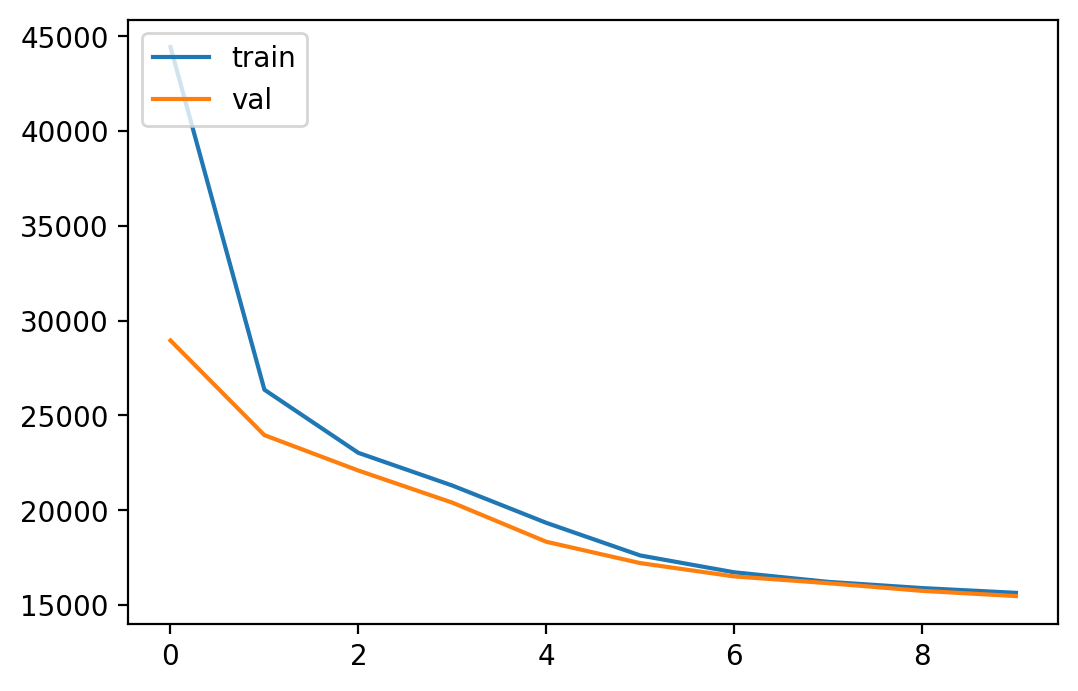

In [ ]:
plt.plot(train_losses)
plt.plot(val_losses)
plt.legend(['train', 'val'], loc='upper left')
# plt.show()

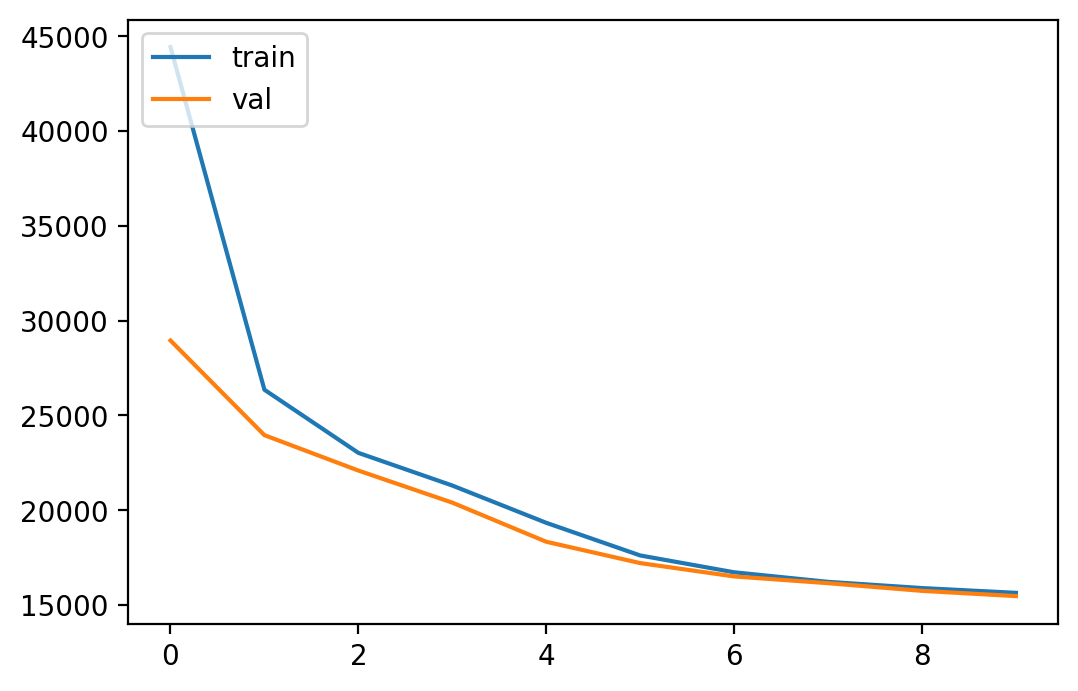

In [ ]:
plt.plot(train_img_loss)
plt.plot(test_img_loss)
plt.legend(['train', 'val'], loc='upper left')
# plt.show()

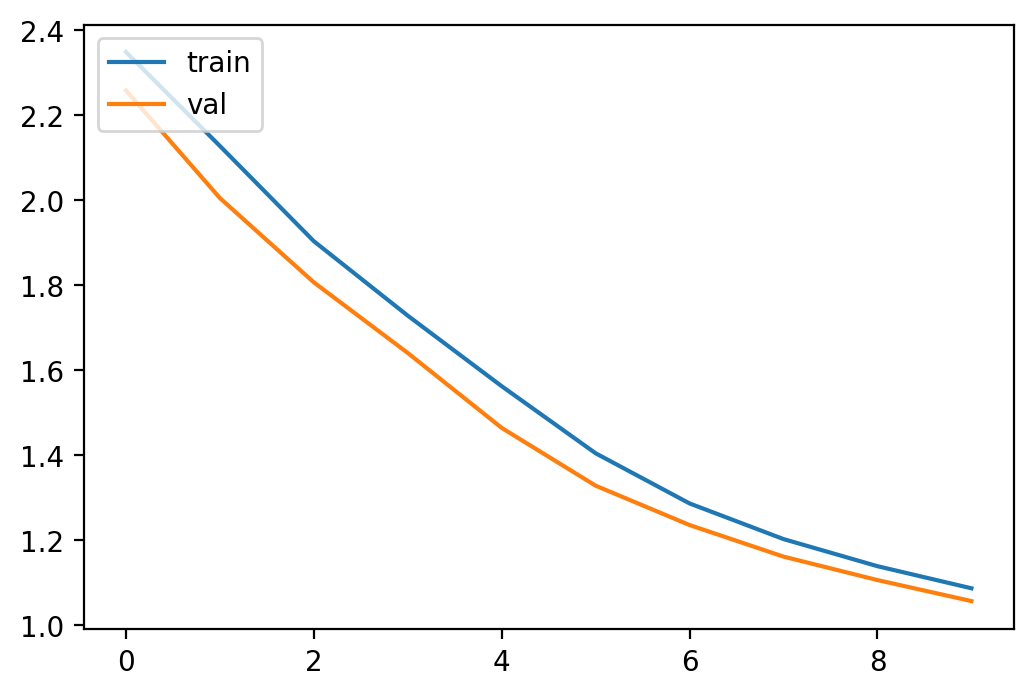

In [ ]:
plt.plot(train_label_loss)
plt.plot(test_label_loss)
plt.legend(['train', 'val'], loc='upper left')
# plt.show()

## Evaluate predictions

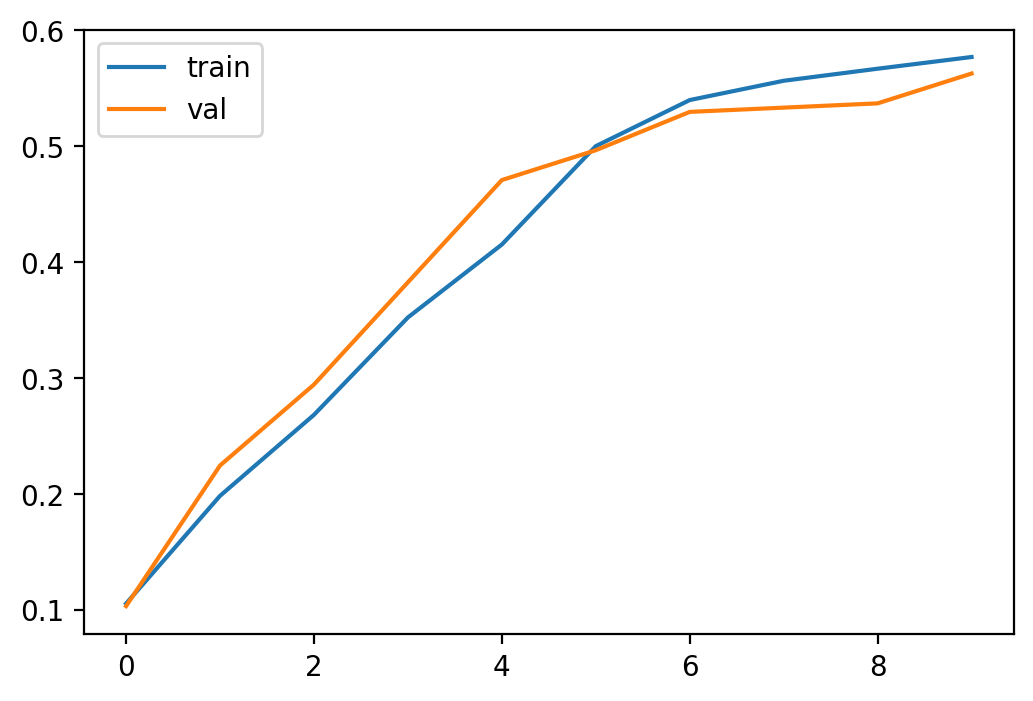

In [ ]:
plt.plot(train_accuracy)
plt.plot(val_accuracy)
plt.legend(['train', 'val'], loc='upper left')
# plt.show()

In [ ]:
train_accuracy , val_accuracy

([0.10513333333333333,
  0.19808333333333333,
  0.268,
  0.35201666666666664,
  0.41495,
  0.49985,
  0.5396166666666666,
  0.5562666666666667,
  0.5666666666666667,
  0.5767666666666666],
 [0.10294117647058823,
  0.22426470588235295,
  0.29411764705882354,
  0.38235294117647056,
  0.47058823529411764,
  0.4963235294117647,
  0.5294117647058824,
  0.5330882352941176,
  0.5367647058823529,
  0.5625])

In [ ]:
autoencoder_80.eval()
correct = 0.
total = 0.
with torch.no_grad():
    for x, y in train_data:
        x = x.to(device) # GPU
        y = F.one_hot(y, num_classes)
        y = y.to(device)
        # print(torch.argmax(y, dim = 1))
        img_loss, predicted = autoencoder_100(x, y.float())
        # print(torch.argmax(predicted, dim = 1))
        total += y.size(0)
        # print('Real : {}, Predicted : {}'.format(y, label_loss))
        # print(' Predicted : {}'.format(torch.argmax(predicted.softmax(dim = 1), dim = 1)))
        # print(predicted.shape, y.shape)
        # print(torch.argmax(predicted, dim = 1), torch.argmax(y, dim = 1))
        correct += (torch.argmax(predicted, dim = 1) == torch.argmax(y, dim = 1)).sum().item()
        # print(correct, total)
    accuracy = 100 * correct / total
    print('Training accuracy:', accuracy)

correct = 0.
total = 0.
with torch.no_grad():
    for x, y in test_data:
        x = x.to(device) # GPU
        y = F.one_hot(y, num_classes)
        y = y.to(device)
        img_loss, predicted = autoencoder_100(x, y.float())
        total += y.size(0)
        # print('Real : {}, Predicted : {}'.format(y, label_loss))
        # print(' Predicted : {}'.format(torch.argmax(predicted.softmax(dim = 1), dim = 1)))
        # print(predicted.shape, y.shape)
        # print(torch.argmax(predicted, dim = 1), torch.argmax(y, dim = 1))
        correct += (torch.argmax(predicted, dim = 1) == torch.argmax(y, dim = 1)).sum().item()
        # print(correct, total)
    accuracy = 100 * correct / total
    print('Testing accuracy:', accuracy)
        
    

Training accuracy: 58.97833333333333
Testing accuracy: 59.09


## Plotting Latent representations

In [ ]:
# def plot_latent(autoencoder, data, num_batches=100):
#     for i, (x, y) in enumerate(data):
#         z = autoencoder.encoder(x.to(device))
#         z = z.to('cpu').detach().numpy()
#         plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
#         if i > num_batches:
#             plt.colorbar()
#             break


def plot_latent_with_label(autoencoder, data, random_labels, num_batches=100):
    if not random_labels:
        for i, (x, y) in enumerate(data):
            x = x.to(device) # GPU
            y_one_hot = F.one_hot(y, num_classes)
            y_one_hot = y_one_hot.to(device)
            z = autoencoder.encoder(x, y_one_hot.float())
            z = z.to('cpu').detach().numpy()
            plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
            if i > num_batches:
                plt.colorbar()
                break

    else:
        for i, (x, y) in enumerate(data):
            x = x.to(device) # GPU
            y_rand = torch.zeros((128, 11))
            y_rand = y_rand.to(device)
            z = autoencoder.encoder(x, y_rand.float())
            z = z.to('cpu').detach().numpy()
            plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
            if i > num_batches:
                plt.colorbar()
                break
    

## checking how much the network depends on the labels

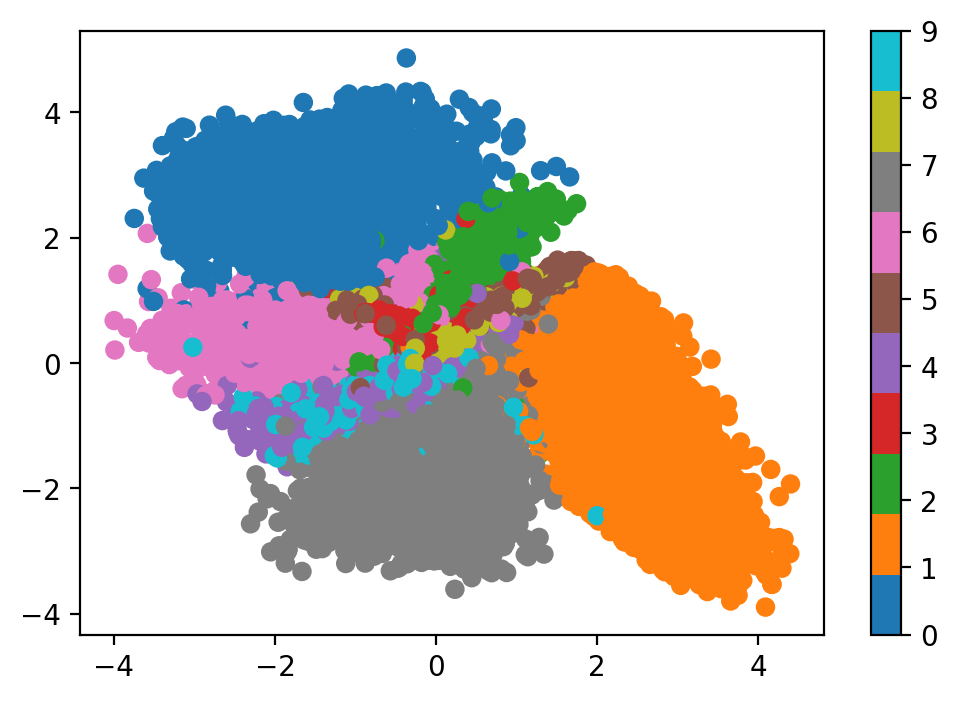

In [ ]:
plot_latent_with_label(autoencoder_80, train_data, random_labels=False) 

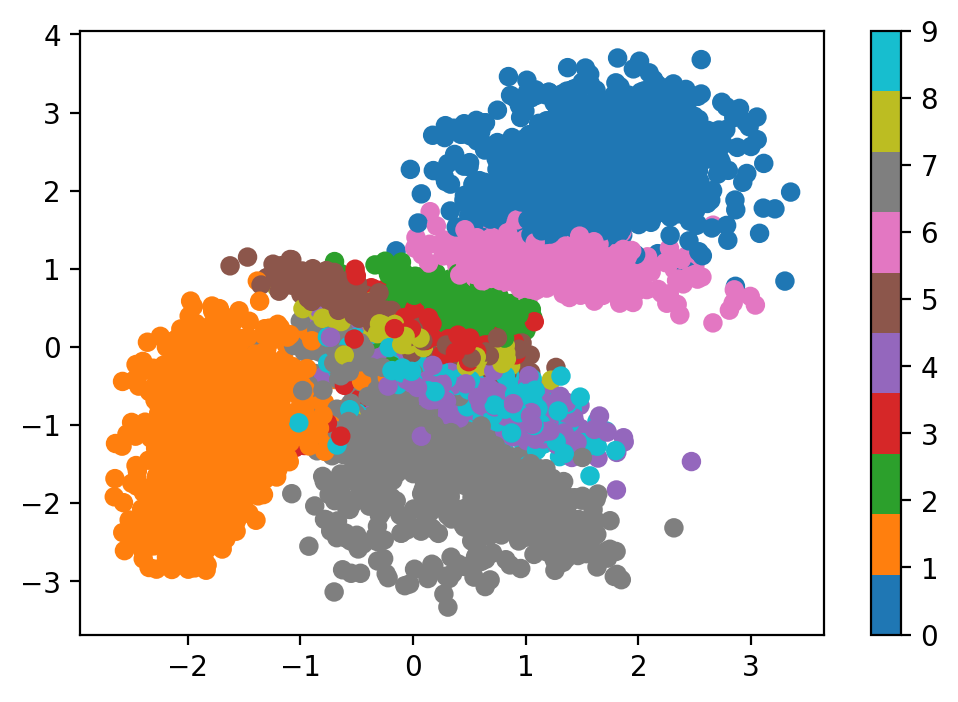

In [ ]:
plot_latent_with_label(autoencoder_100, data, random_labels=False) 

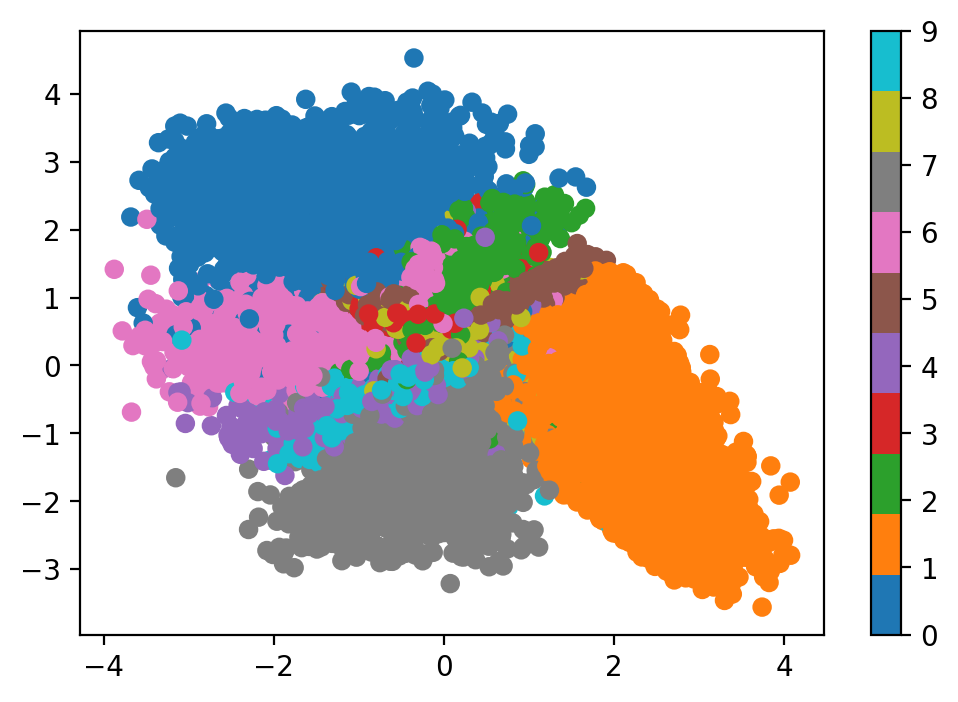

In [ ]:
plot_latent_with_label(autoencoder_80, train_data, random_labels=True) 

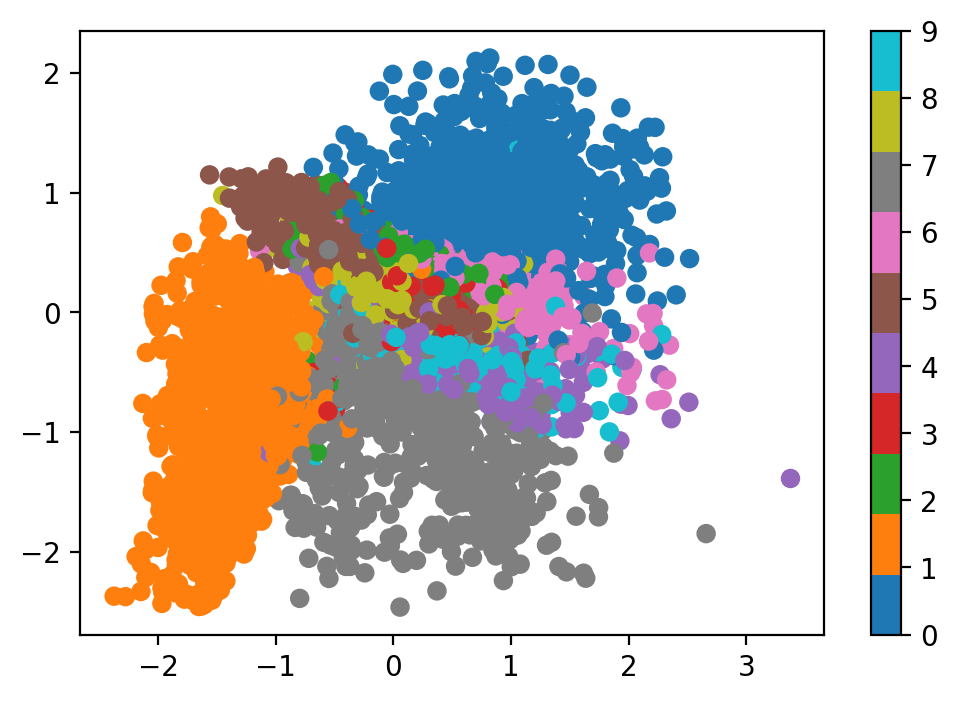

In [ ]:
plot_latent_with_label(autoencoder_100, data, random_labels=True) 

The resulting latent vectors cluster similar digits together. We can also sample uniformly from the latent space and see how the decoder reconstructs inputs from arbitrary latent vectors.

In [ ]:
def plot_reconstructed(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

def plot_reconstructed_with_labels(autoencoder, r0=(-5, 10), r1=(-10, 5), n=12):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat, label = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])

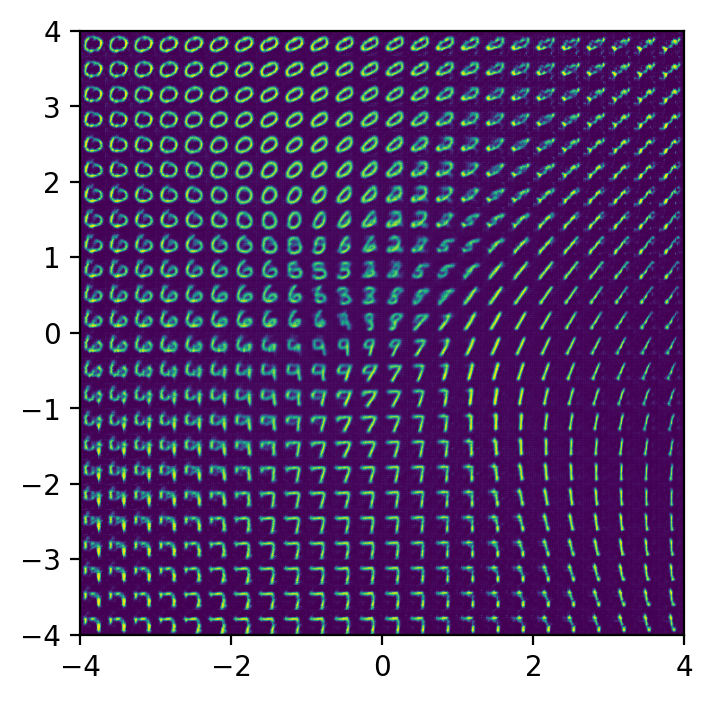

In [ ]:
def plot_reconstructed_with_labels(autoencoder, r0=(-4, 4), r1=(-4, 4), n=24):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat, label = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
plot_reconstructed_with_labels(autoencoder_80)

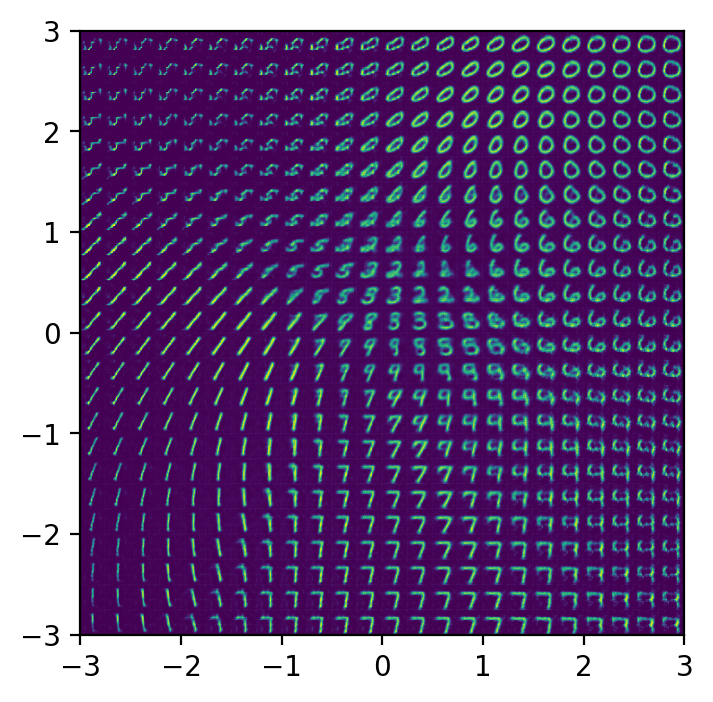

In [ ]:
def plot_reconstructed_with_labels(autoencoder, r0=(-3, 3), r1=(-3, 3), n=24):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat, label = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
plot_reconstructed_with_labels(autoencoder_100)

# Main code to run code on various models while varying the amount of training data

## Setting up the model

In [ ]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim, num_classes):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_labels_lin = nn.Linear(num_classes, num_classes//2)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32 + num_classes//2, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
        
    def forward(self, x, y):
        img_features = self.encoder_cnn(x)
        img_features = self.flatten(img_features)
        label_features = self.encoder_labels_lin(y)
        combined = torch.cat((img_features, label_features), dim = -1)
        out = self.encoder_lin(combined)
        return out

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, num_classes):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32 + (num_classes)//2),
            nn.ReLU(True)
        )
        self.decoder_labels_lin = nn.Linear((num_classes)//2, num_classes)
        
        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        img_features = x[:, :-(num_classes//2)]
        label_features = x[:, -(num_classes//2):]
        img_features = self.unflatten(img_features)
        img_features = self.decoder_conv(img_features)
        img = torch.sigmoid(img_features)
        label = self.decoder_labels_lin(label_features)
        return img, label

In [ ]:
class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # self.gamma = nn.Parameter(torch.tensor([.5]))
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, img, pred_img, label, pred_label):
        mse_loss_img = ((img - pred_img)**2).sum()
        mse_loss_label = self.cross_entropy(pred_label, label.float())
        # loss = mse_loss_img * torch.sigmoid(self.gamma) + \
              # mse_loss_label * (1 - torch.sigmoid(self.gamma))
        loss = mse_loss_img + mse_loss_label#*torch.sigmoid(self.gamma)
        return mse_loss_img, mse_loss_label, loss

class Autoencoder(nn.Module):
    def __init__(self, latent_dims, num_classes):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims, num_classes)
        self.decoder = Decoder(latent_dims, num_classes)
        self.custom_loss = CustomLoss()
        self.num_classes = num_classes
    
    def forward(self, x, y):
        z = self.encoder(x, y)
        return self.decoder(z)

    def test_epoch(self, test_data):
    # Set evaluation mode for encoder and decoder
        self.eval()
        with torch.no_grad(): # No need to track the gradients
            # Define the lists to store the outputs for each batch
            test_img_loss = []
            test_label_loss = []
            total_test_loss = []
            for image_batch, label_batch in test_data:
                total = 0
                correct = 0
                # Move tensor to the proper device
                image_batch = image_batch.to(device)
                label_batch = F.one_hot(label_batch, num_classes=self.num_classes)
                label_batch = label_batch.to(device)
                pred_img, pred_label = self.forward(image_batch, label_batch.float()) 
                # Append the network output and the original image to the lists
                img_loss, label_loss, total_loss = self.custom_loss(image_batch,
                                                                pred_img, 
                                                                label_batch, 
                                                                pred_label)
                total += label_batch.size(0)
                correct += (torch.argmax(pred_label, dim = 1) == torch.argmax(label_batch, dim = 1)).sum().item()
                test_img_loss.append(img_loss.item())
                test_label_loss.append(label_loss.item())
                total_test_loss.append(total_loss.item())
        test_img_loss = sum(test_img_loss)/len(test_img_loss)
        test_label_loss = sum(test_label_loss)/len(test_label_loss)
        total_test_loss = sum(total_test_loss)/len(total_test_loss)
        test_accuracy = correct/total
        return test_img_loss, test_label_loss, total_test_loss, test_accuracy

    def train_epoch(self, train_data, optimizer, training_label_ratio):
        self.train()
        torch.manual_seed(0)
        train_img_loss = []
        train_label_loss = []
        train_loss = []
        correct = 0
        total = 0
        for image_batch, label_batch in train_data:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            num_training_examples = label_batch.shape[0]
            num_non_label_training_examples = num_training_examples*(1-training_label_ratio)
            non_label_training_idx = random.sample(range(num_training_examples),int(num_non_label_training_examples))
            label_batch[[non_label_training_idx]] = self.num_classes - 1
            label_batch = F.one_hot(label_batch, num_classes=self.num_classes)
            label_batch = label_batch.to(device)
            optimizer.zero_grad()
            pred_img, pred_label = self.forward(image_batch, label_batch.float()) 
            # Append the network output and the original image to the lists
            img_loss, label_loss, total_loss = self.custom_loss(image_batch,
                                                            pred_img, 
                                                            label_batch, 
                                                            pred_label)
            total_loss.backward()
            optimizer.step()
            train_img_loss.append(img_loss.item())
            train_label_loss.append(label_loss.item())
            train_loss.append(total_loss.item())
            total += label_batch.size(0)
            correct += (torch.argmax(pred_label, dim = 1) == torch.argmax(label_batch, dim = 1)).sum().item()
        train_img_loss = sum(train_img_loss)/len(train_img_loss)
        train_label_loss = sum(train_label_loss)/len(train_label_loss)
        train_loss = sum(train_loss)/len(train_loss)
        train_accuracy = correct/total
        return train_img_loss, train_label_loss, train_loss, train_accuracy

    def training_loop(self, train_data, test_data,training_label_ratio,
                      epochs, optimizer):
        train_losses = []
        val_losses = []
        train_img_losses = []
        val_img_losses = []
        train_label_losses = []
        val_label_losses = []
        train_accuracies = []
        val_accuracies = []
        for epoch in tqdm(range(epochs)):
          train_img_loss, train_label_loss, train_loss, train_accuracy =self.train_epoch(train_data, optimizer, 
                                             training_label_ratio)
          val_img_loss, val_label_loss, val_loss, val_accuracy = self.test_epoch(test_data)
          train_losses.append(train_loss)
          val_losses.append(val_loss)
          train_img_losses.append(train_img_loss)
          val_img_losses.append(val_img_loss)
          train_label_losses.append(train_label_loss)
          val_label_losses.append(val_label_loss)
          train_accuracies.append(train_accuracy)
          val_accuracies.append(val_accuracy)
          wandb.log({"train_img_loss": train_img_loss, 
            "train_label_loss":train_label_loss, 
            "val_img_loss":val_img_loss, 
            "val_label_loss":val_label_loss, 
            "train_losses":train_loss, 
            "val_losses":val_loss, 
            "train_accuracy":train_accuracy, 
            "val_accuracy":val_accuracy})

        return train_img_losses, train_label_losses, val_img_losses, val_label_losses ,train_losses, val_losses, train_accuracies, val_accuracies

def plot_latent_with_label(autoencoder, batch_size, data, random_labels,
                           num_classes, num_batches=100):
    if not random_labels:
        for i, (x, y) in enumerate(data):
            x = x.to(device) # GPU
            y_one_hot = F.one_hot(y, num_classes)
            y_one_hot = y_one_hot.to(device)
            z = autoencoder.encoder(x, y_one_hot.float())
            z = z.to('cpu').detach().numpy()
            plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
            if i > num_batches:
                plt.colorbar()
                break
        wandb.log({"Latent : Real labels in input": plt})
    else:
        for i, (x, y) in enumerate(data):
            x = x.to(device) # GPU
            y_rand = torch.zeros((x.size(0), num_classes))
            y_rand = y_rand.to(device)
            z = autoencoder.encoder(x, y_rand.float())
            z = z.to('cpu').detach().numpy()
            plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
            if i > num_batches:
                plt.colorbar()
                break
        wandb.log({"Latent : Random labels in input": plt})
    return min(z[:, 0]), max(z[:, 0]), min(z[:, 1]), max(z[:, 1])


def plot_reconstructed_with_labels(autoencoder,random_labels, r0,
                                   r1, n=24):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat, label = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
    if not random_labels:
      wandb.log({"Reconstruction : Real labels in input": plt})
    else:
      wandb.log({"Reconstruction : Random labels in input": plt})
    
    

## Training multiple networks

In [ ]:
def wandb_init(epochs, lr, label_ratio, batch_size, model_number):
  wandb.init(project="ConceptualAlignmentLangugae", entity="psych-711")
  wandb.config = {
    "learning_rate": lr,
    "epochs": epochs,
    "batch_size": batch_size, 
    "label_ratio":label_ratio, 
    "model_number": model_number 
  }
  wandb.run.name = '{}_{}'.format(label_ratio, model_number)
  wandb.run.save()
     

In [ ]:
def main_code(save_dir, num_models, epochs, num_classes, batch_size,
             lr, latent_dims):
  if os.path.isdir(save_dir):
    pass
  else:
    os.mkdir(save_dir)

  for i in tqdm(range(0, 11)):
    torch.manual_seed(0)
    label_ratio = i/10
    for model in range(num_models):
      wandb_init(epochs, lr, label_ratio, batch_size, model)
      train_data = torch.utils.data.DataLoader( 
        torchvision.datasets.MNIST('./data', 
               transform=torchvision.transforms.ToTensor(), train = True, 
               download=True),
        batch_size=batch_size,
        shuffle=True)
      train_data, val_data = torch.utils.data.random_split(train_data.dataset, 
                                                           [50000, 10000])
      train_data = torch.utils.data.DataLoader(train_data, 
                                               batch_size=batch_size,
                                            shuffle=True)
      val_data = torch.utils.data.DataLoader(val_data, 
                                               batch_size=batch_size,
                                            shuffle=True)
      test_data = torch.utils.data.DataLoader( 
              torchvision.datasets.MNIST('./data', 
                    transform=torchvision.transforms.ToTensor(), train = False, 
                    download=True),
              batch_size=batch_size,
              shuffle=True)
      autoencoder = Autoencoder(latent_dims, num_classes).to(device) # GPU
      optimizer = torch.optim.Adam(autoencoder.parameters(), lr=lr, weight_decay=1e-05)
      train_img_loss, train_label_loss, val_img_loss, \
      val_label_loss ,train_losses, val_losses,  train_accuracy, \
      val_accuracy= autoencoder.training_loop(train_data = train_data,
                                                          test_data = test_data,
                                                          epochs = epochs,
                                                          optimizer = optimizer, 
                                                          training_label_ratio = label_ratio)
      # figure out which data we want to plot

      min_x, max_x, min_y, max_y = plot_latent_with_label(autoencoder, 
                                                          batch_size, 
                                                          data=val_data, 
                                                          random_labels = False,
                                                          num_classes = num_classes,
                                                          num_batches=100)
      plt.clf()
      plot_reconstructed_with_labels(autoencoder = autoencoder, 
                                     r0=(min_x, max_x),
                                    r1=(min_y, max_y), 
                                     n=24, random_labels = False)
      plt.clf()
      min_x, max_x, min_y, max_y = plot_latent_with_label(autoencoder, 
                                                          batch_size, 
                                                          data=val_data, 
                                                          random_labels = True,
                                                          num_classes = num_classes,
                                                          num_batches=100)
      plt.clf()
      plot_reconstructed_with_labels(autoencoder = autoencoder, 
                                     r0=(min_x, max_x),
                                    r1=(min_y, max_y), 
                                     n=24, random_labels = True)
      plt.clf()
      
      # wandb.log({"train_img_loss": train_img_loss, 
      #            "train_label_loss":train_label_loss, 
      #            "val_img_loss":val_img_loss, 
      #            "val_label_loss":val_label_loss, 
      #            "train_losses":train_losses, 
      #            "val_losses":val_losses, 
      #            "train_accuracy":train_accuracy, 
      #            "val_accuracy":val_accuracy})
      torch.save(autoencoder.state_dict(), save_dir+'_{}_{}'.format(label_ratio, 
                                                                    model))
      
      


## Main program code

In [ ]:
num_classes = 11 # Number of unique class labels in the dataset
latent_dims = 2
epochs = 20
lr = 0.001
num_models = 2
batch_size = 512
save_dir = base_dir + 'results/'
main_code(save_dir, num_models, epochs, num_classes, batch_size,
             lr, latent_dims)

  0%|          | 0/11 [00:00<?, ?it/s]

train_accuracy,▁████████
train_img_loss,█▄▂▂▁▁▁▁▁
train_label_loss,█▃▁▁▁▁▁▁▁
train_losses,█▄▂▂▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁
val_img_loss,█▄▃▂▂▁▁▁▁
val_label_loss,▁▆████▇▇▇
val_losses,█▄▃▂▂▁▁▁▁
train_accuracy,0.89844
train_img_loss,17339.35171
train_label_loss,0.57038



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


train_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_img_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_img_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,▁▂▄▅▅▆▆▇▇▇▇▇█▇██████
val_losses,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,1.0
train_img_loss,15509.79588
train_label_loss,0.00014



  9%|▉         | 1/11 [04:02<40:20, 242.00s/it]

train_accuracy,▁███████████████████
train_img_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▃▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_img_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,▁▂▂▃▃▅▆▇▇▇▇█████████
val_losses,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,1.0
train_img_loss,15551.60199
train_label_loss,2e-05



100%|██████████| 20/20 [01:43<00:00,  5.18s/it]


train_accuracy,██████████████▁█████
train_img_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_img_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,▃█▇▆▆▆▅▄▃▃▂▂▂▂▁▁▁▁▁▁
val_losses,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.89844
train_img_loss,15506.87135
train_label_loss,0.45375



 18%|█▊        | 2/11 [08:05<36:26, 242.89s/it]

train_accuracy,▁███████████████████
train_img_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_img_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,▁▆█████▇▇▆▆▅▄▄▄▄▃▄▃▃
val_losses,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.89844
train_img_loss,15550.60742
train_label_loss,0.45083



100%|██████████| 20/20 [01:41<00:00,  5.09s/it]


train_accuracy,█████▄▇▆▃▁▇▃▇▆▇█████
train_img_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁█▁▁██▁█▁▁▁▁▁▁▁
val_img_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,▇█▇▇▆▄▄▃▃▂▂▂▂▂▂▁▁▁▁▁
val_losses,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.79884
train_img_loss,15484.76946
train_label_loss,0.68859



 27%|██▋       | 3/11 [12:05<32:12, 241.52s/it]

train_accuracy,▁███████████████████
train_img_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_img_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,▁██▇▇▆▆▆▅▅▅▅▅▅▅▅▅▅▅▄
val_losses,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.79882
train_img_loss,15657.6776
train_label_loss,0.84858



100%|██████████| 20/20 [01:40<00:00,  5.02s/it]


train_accuracy,████████████▂▁▂▄▃▄▄▃
train_img_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
train_losses,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▁███▁██▁█
val_img_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,▇███▇▇▆▅▅▅▄▃▂▂▂▁▁▁▁▁
val_losses,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.69852
train_img_loss,15497.19458
train_label_loss,1.02442



 36%|███▋      | 4/11 [16:05<28:05, 240.77s/it]

train_accuracy,▁███████████████████
train_img_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▅▁██▅█▅▅▅███
val_img_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,▄█▇▆▅▄▄▃▃▂▂▂▂▂▂▂▁▁▁▁
val_losses,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.69644
train_img_loss,15476.3449
train_label_loss,0.94074



100%|██████████| 20/20 [01:40<00:00,  5.02s/it]


train_accuracy,███████████▇▅▂▃▂▂▁▂▁
train_img_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▆▅▅▄▄▄▃▃▃▃▃▂▁▁▁▁▁▁▁
train_losses,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▁▁▁▁▁▁▁▂▅▄▆▇▄▅▅█
val_img_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,▇███▇▆▅▅▅▅▅▃▂▂▂▂▁▂▁▁
val_losses,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.59316
train_img_loss,15339.67354
train_label_loss,1.11741



 45%|████▌     | 5/11 [20:03<23:58, 239.82s/it]

train_accuracy,▁███████████████████
train_img_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▅▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▁▁▃▃▅▅▅▅▅▅▃▆▅▅▅▃█▅
val_img_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,▆█▇▆▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
val_losses,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.59182
train_img_loss,15508.10091
train_label_loss,1.07121



100%|██████████| 20/20 [01:40<00:00,  5.02s/it]


train_accuracy,▂▂▂▅▆▃█▃██▅▆▄▂▃▃▄▃▄▁
train_img_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▆▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁
train_losses,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▃▄▅▅▅▅▆▆▆▆▆▆▆▆█▇█
val_img_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,██▇▆▄▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁
val_losses,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.49904
train_img_loss,15508.03589
train_label_loss,1.17273



 55%|█████▍    | 6/11 [24:01<19:57, 239.48s/it]

train_accuracy,▁███████████████████
train_img_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▆▅▄▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▂▄▃▃▅▅▅▆▇▇▇███▇██
val_img_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,▇█▇▆▅▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁
val_losses,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.50336
train_img_loss,15524.33342
train_label_loss,1.12102



100%|██████████| 20/20 [01:40<00:00,  5.00s/it]


train_accuracy,▁▁▂▂▄▅▅▅▆▆▆▆▆▆▆▆▇▇██
train_img_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▇▆▅▄▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁
train_losses,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▂▃▄▅▅▆▅▆▆▆▆▆▆████
val_img_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,██▇▅▄▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁
val_losses,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.46722
train_img_loss,15535.84092
train_label_loss,1.21651



 64%|██████▎   | 7/11 [28:00<15:56, 239.05s/it]

train_accuracy,▁▆▆▆▆▆▇▇▇▇██████████
train_img_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▆▅▅▄▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁
train_losses,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▂▂▃▅▅▆▆▆▆▇▇▇▇████
val_img_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,██▇▆▅▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁
val_losses,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.4613
train_img_loss,15562.66386
train_label_loss,1.4157



100%|██████████| 20/20 [01:39<00:00,  5.00s/it]


train_accuracy,▁▁▂▄▇▇▇▇████████████
train_img_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,██▇▅▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_losses,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▅▅▅▆▆▆▆▇▇▇▇▇▇▇▇██
val_img_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,██▇▄▃▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁
val_losses,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.40916
train_img_loss,15546.93539
train_label_loss,1.4115



 73%|███████▎  | 8/11 [31:57<11:55, 238.66s/it]

train_accuracy,▁▄▄▄▅▅▆▇▇▇██████████
train_img_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▇▆▅▄▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
train_losses,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▃▄▅▆▇▇▇████▇█████
val_img_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,██▆▅▄▄▃▃▂▂▂▂▁▁▁▁▁▁▁▁
val_losses,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.44858
train_img_loss,15474.21434
train_label_loss,1.45567



100%|██████████| 20/20 [01:40<00:00,  5.01s/it]


train_accuracy,▁▁▂▄▅▅▆▆▆▇▇▇▇▇▇█████
train_img_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,██▇▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
train_losses,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▃▄▅▆▆▇▇▇▇▇▇▇▇█████
val_img_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,██▆▄▃▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁
val_losses,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.53226
train_img_loss,15455.73702
train_label_loss,1.25711



 82%|████████▏ | 9/11 [35:55<07:56, 238.38s/it]

train_accuracy,▁▂▄▅▆▆▇▇▇███████████
train_img_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▇▆▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁
train_losses,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▄▅▆▆▇▇▇▇▇█████████
val_img_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,█▇▅▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_losses,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.60892
train_img_loss,15476.57475
train_label_loss,1.08443



100%|██████████| 20/20 [01:40<00:00,  5.01s/it]


train_accuracy,▁▁▁▁▂▃▄▆▇▇▇▇▇█▇█████
train_img_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,███▇▆▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁
train_losses,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▁▂▂▃▄▅▆▇▇▇▇█▇██████
val_img_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,███▇▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁
val_losses,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.49802
train_img_loss,15376.30651
train_label_loss,1.39924



 91%|█████████ | 10/11 [39:53<03:58, 238.09s/it]

train_accuracy,▁▃▄▅▇▇▇▇████████████
train_img_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,█▇▅▄▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁
train_losses,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▅▆▇▇▇▇▇▇▇█▇███████
val_img_loss,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,█▆▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁
val_losses,█▄▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.6772
train_img_loss,15154.18736
train_label_loss,0.92597



100%|██████████| 20/20 [01:39<00:00,  4.98s/it]


train_accuracy,▁▂▃▅▆▆▆▆▇▇▇▇████████
train_img_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_label_loss,██▆▅▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁
train_losses,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▃▆▅▆▆▆▇▇▇▇████████
val_img_loss,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_label_loss,█▇▆▄▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁
val_losses,█▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_accuracy,0.74636
train_img_loss,14981.4999
train_label_loss,0.7366



100%|██████████| 11/11 [43:51<00:00, 239.23s/it]


<Figure size 1200x800 with 0 Axes>

# Code to compute RDMs and their correlations

## Setting up the model

In [15]:
class Encoder(nn.Module):
    def __init__(self, encoded_space_dim, num_classes):
        super().__init__()
        self.num_classes = num_classes # added to make the visualisation function work
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        self.encoder_labels_lin = nn.Linear(self.num_classes, self.num_classes//2)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32 + self.num_classes//2, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
        
    def forward(self, x, y):
        img_features = self.encoder_cnn(x)
        img_features = self.flatten(img_features)
        label_features = self.encoder_labels_lin(y)
        combined = torch.cat((img_features, label_features), dim = -1)
        out = self.encoder_lin(combined)
        return out

class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim, num_classes):
        super().__init__()
        self.num_classes = num_classes
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32 + (num_classes)//2),
            nn.ReLU(True)
        )
        self.decoder_labels_lin = nn.Linear((self.num_classes)//2, self.num_classes)
        
        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        img_features = x[:, :-(self.num_classes//2)]
        label_features = x[:, -(self.num_classes//2):]
        img_features = self.unflatten(img_features)
        img_features = self.decoder_conv(img_features)
        img = torch.sigmoid(img_features)
        label = self.decoder_labels_lin(label_features)
        return img, label

In [16]:
class CustomLoss(nn.Module):
    def __init__(self):
        super().__init__()
        # self.gamma = nn.Parameter(torch.tensor([.5]))
        self.cross_entropy = nn.CrossEntropyLoss()

    def forward(self, img, pred_img, label, pred_label):
        mse_loss_img = ((img - pred_img)**2).sum()
        mse_loss_label = self.cross_entropy(pred_label, label.float())
        # loss = mse_loss_img * torch.sigmoid(self.gamma) + \
              # mse_loss_label * (1 - torch.sigmoid(self.gamma))
        loss = mse_loss_img + mse_loss_label#*torch.sigmoid(self.gamma)
        return mse_loss_img, mse_loss_label, loss

class Autoencoder(nn.Module):
    def __init__(self, latent_dims, num_classes):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder(latent_dims, num_classes)
        self.decoder = Decoder(latent_dims, num_classes)
        self.custom_loss = CustomLoss()
        self.num_classes = num_classes
    
    def forward(self, x, y):
        z = self.encoder(x, y)
        return self.decoder(z)

    def test_epoch(self, test_data):
    # Set evaluation mode for encoder and decoder
        self.eval()
        with torch.no_grad(): # No need to track the gradients
            # Define the lists to store the outputs for each batch
            test_img_loss = []
            test_label_loss = []
            total_test_loss = []
            for image_batch, label_batch in test_data:
                total = 0
                correct = 0
                # Move tensor to the proper device
                image_batch = image_batch.to(device)
                label_batch = F.one_hot(label_batch, num_classes=self.num_classes)
                label_batch = label_batch.to(device)
                pred_img, pred_label = self.forward(image_batch, label_batch.float()) 
                # Append the network output and the original image to the lists
                img_loss, label_loss, total_loss = self.custom_loss(image_batch,
                                                                pred_img, 
                                                                label_batch, 
                                                                pred_label)
                total += label_batch.size(0)
                correct += (torch.argmax(pred_label, dim = 1) == torch.argmax(label_batch, dim = 1)).sum().item()
                test_img_loss.append(img_loss.item())
                test_label_loss.append(label_loss.item())
                total_test_loss.append(total_loss.item())
        test_img_loss = sum(test_img_loss)/len(test_img_loss)
        test_label_loss = sum(test_label_loss)/len(test_label_loss)
        total_test_loss = sum(total_test_loss)/len(total_test_loss)
        test_accuracy = correct/total
        return test_img_loss, test_label_loss, total_test_loss, test_accuracy

    def train_epoch(self, train_data, optimizer, training_label_ratio):
        self.train()
        torch.manual_seed(0)
        train_img_loss = []
        train_label_loss = []
        train_loss = []
        correct = 0
        total = 0
        for image_batch, label_batch in train_data:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            num_training_examples = label_batch.shape[0]
            num_non_label_training_examples = num_training_examples*(1-training_label_ratio)
            non_label_training_idx = random.sample(range(num_training_examples),int(num_non_label_training_examples))
            label_batch[[non_label_training_idx]] = self.num_classes - 1
            label_batch = F.one_hot(label_batch, num_classes=self.num_classes)
            label_batch = label_batch.to(device)
            optimizer.zero_grad()
            pred_img, pred_label = self.forward(image_batch, label_batch.float()) 
            # Append the network output and the original image to the lists
            img_loss, label_loss, total_loss = self.custom_loss(image_batch,
                                                            pred_img, 
                                                            label_batch, 
                                                            pred_label)
            total_loss.backward()
            optimizer.step()
            train_img_loss.append(img_loss.item())
            train_label_loss.append(label_loss.item())
            train_loss.append(total_loss.item())
            total += label_batch.size(0)
            correct += (torch.argmax(pred_label, dim = 1) == torch.argmax(label_batch, dim = 1)).sum().item()
        train_img_loss = sum(train_img_loss)/len(train_img_loss)
        train_label_loss = sum(train_label_loss)/len(train_label_loss)
        train_loss = sum(train_loss)/len(train_loss)
        train_accuracy = correct/total
        return train_img_loss, train_label_loss, train_loss, train_accuracy

    def training_loop(self, train_data, test_data,training_label_ratio,
                      epochs, optimizer):
        train_losses = []
        val_losses = []
        train_img_losses = []
        val_img_losses = []
        train_label_losses = []
        val_label_losses = []
        train_accuracies = []
        val_accuracies = []
        for epoch in tqdm(range(epochs)):
          train_img_loss, train_label_loss, train_loss, train_accuracy =self.train_epoch(train_data, optimizer, 
                                             training_label_ratio)
          val_img_loss, val_label_loss, val_loss, val_accuracy = self.test_epoch(test_data)
          train_losses.append(train_loss)
          val_losses.append(val_loss)
          train_img_losses.append(train_img_loss)
          val_img_losses.append(val_img_loss)
          train_label_losses.append(train_label_loss)
          val_label_losses.append(val_label_loss)
          train_accuracies.append(train_accuracy)
          val_accuracies.append(val_accuracy)
          wandb.log({"train_img_loss": train_img_loss, 
            "train_label_loss":train_label_loss, 
            "val_img_loss":val_img_loss, 
            "val_label_loss":val_label_loss, 
            "train_losses":train_loss, 
            "val_losses":val_loss, 
            "train_accuracy":train_accuracy, 
            "val_accuracy":val_accuracy})

        return train_img_losses, train_label_losses, val_img_losses, val_label_losses ,train_losses, val_losses, train_accuracies, val_accuracies

def plot_latent_with_label(autoencoder, batch_size, data, random_labels,
                           num_classes, num_batches=100):
    if not random_labels:
        for i, (x, y) in enumerate(data):
            x = x.to(device) # GPU
            y_one_hot = F.one_hot(y, num_classes)
            y_one_hot = y_one_hot.to(device)
            z = autoencoder.encoder(x, y_one_hot.float())
            z = z.to('cpu').detach().numpy()
            plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
            if i > num_batches:
                plt.colorbar()
                break
        wandb.log({"Latent : Real labels in input": plt})
    else:
        for i, (x, y) in enumerate(data):
            x = x.to(device) # GPU
            y_rand = torch.zeros((x.size(0), num_classes))
            y_rand = y_rand.to(device)
            z = autoencoder.encoder(x, y_rand.float())
            z = z.to('cpu').detach().numpy()
            plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
            if i > num_batches:
                plt.colorbar()
                break
        wandb.log({"Latent : Random labels in input": plt})
    return min(z[:, 0]), max(z[:, 0]), min(z[:, 1]), max(z[:, 1])


def plot_reconstructed_with_labels(autoencoder,random_labels, r0,
                                   r1, n=24):
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).to(device)
            x_hat, label = autoencoder.decoder(z)
            x_hat = x_hat.reshape(28, 28).to('cpu').detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    plt.imshow(img, extent=[*r0, *r1])
    if not random_labels:
      wandb.log({"Reconstruction : Real labels in input": plt})
    else:
      wandb.log({"Reconstruction : Random labels in input": plt})
    
    

# Visualise model architecture

In [20]:
!pip install torchviz

  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4150 sha256=e17f34fe3ad739dde5e69bcdbb4f50b9cd860ac33973aaae6299eeaee10c43ab
  Stored in directory: /root/.cache/pip/wheels/04/38/f5/dc4f85c3909051823df49901e72015d2d750bd26b086480ec2
Successfully built torchviz


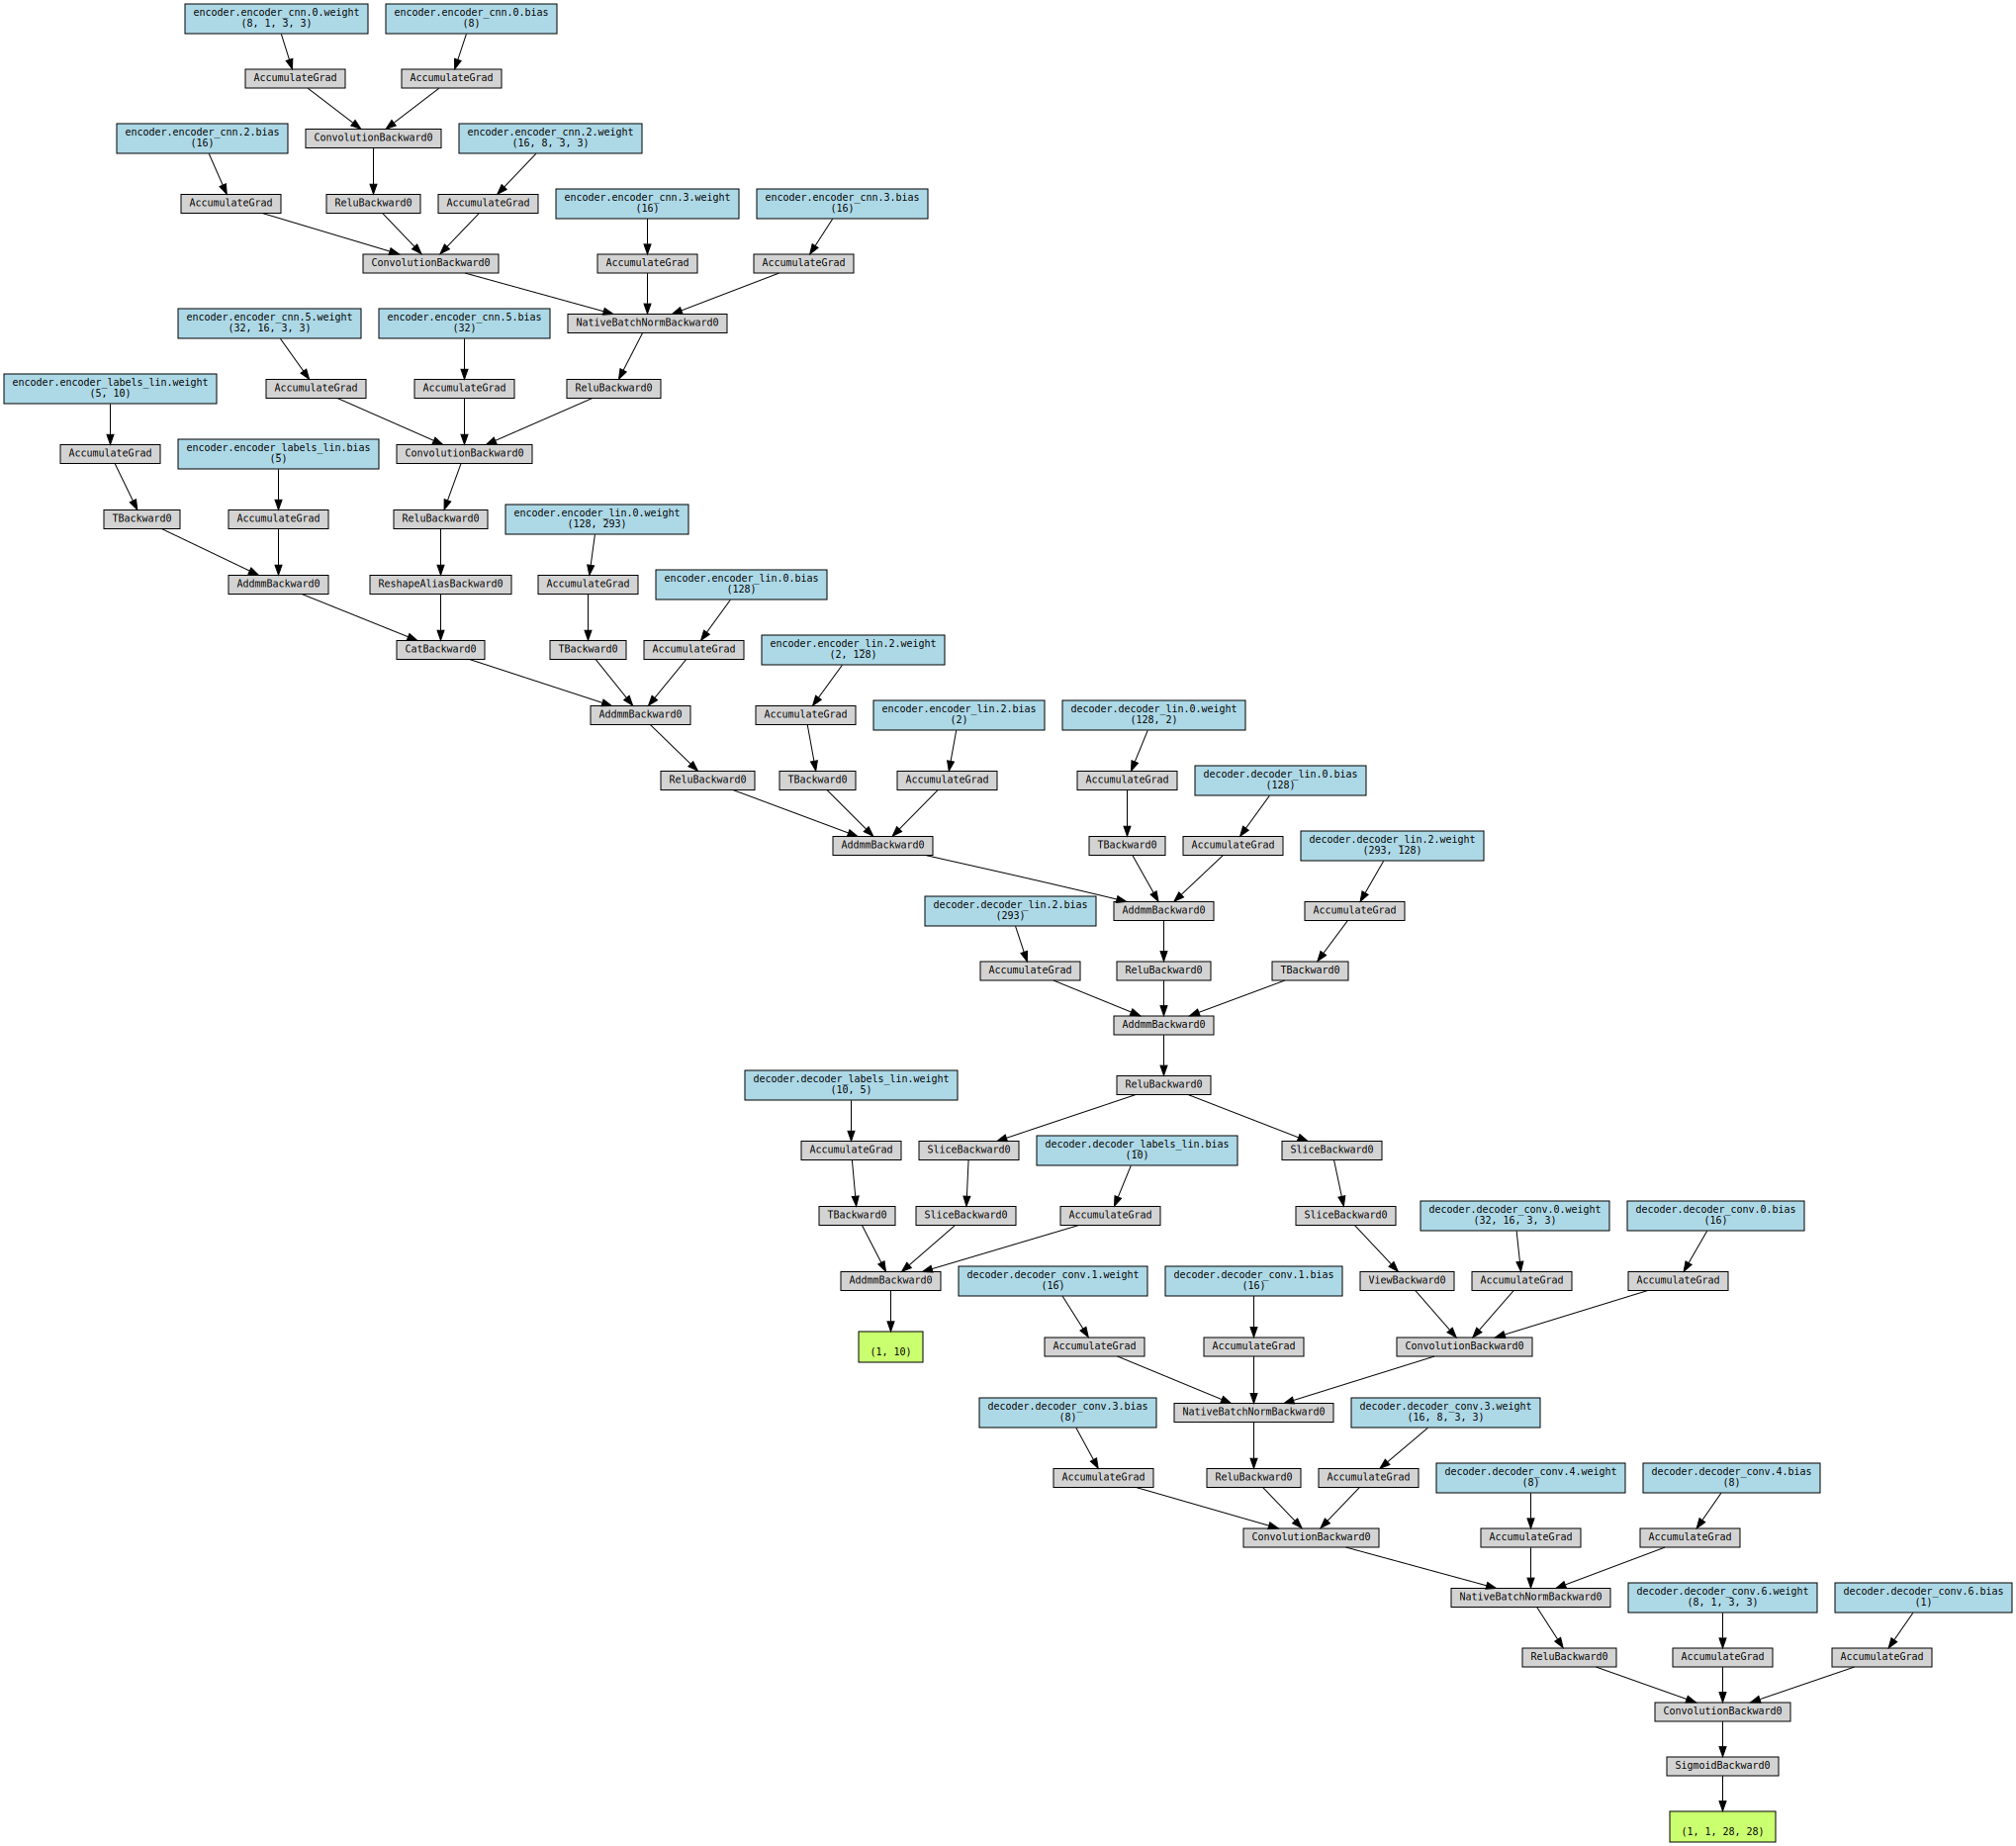

In [25]:


# transforms = [ hl.transforms.Prune('Constant') ] # Removes Constant nodes from graph.
# model = Autoencoder(2, 10)
# graph = hl.build_graph(model, (torch.zeros([1, 1, 28, 28]), torch.zeros([1, 10])), transforms=transforms)
# graph.theme = hl.graph.THEMES['blue'].copy()
# graph.save('rnn_hiddenlayer', format='png')

from torchviz import make_dot
model = Autoencoder(2, 10)
img = torch.randn(1, 1, 28, 28)
label = torch.zeros(1, 10)
y = model(img, label)
make_dot(y, params=dict(list(model.named_parameters())))#.render("rnn_torchviz", format="png")

## Helper functions

In [ ]:
def custom_torch_RSM_fct(features):
  """
  Custom function to calculate representational similarity matrix (RSM) of a feature
  matrix using pairwise cosine similarity.

  Args:
    features: 2D torch.Tensor
      Feature matrix of size (nbr items x nbr features)

  Returns:
    rsm: 2D torch.Tensor
      Similarity matrix of size (nbr items x nbr items)
  """
  features = torch.from_numpy(features)
  num_items, num_features = features.shape

  rsm = torch.nn.functional.cosine_similarity(
      features.reshape(1, num_items, num_features),
      features.reshape(num_items, 1, num_features),
      dim=2
      )

  if not rsm.shape == (num_items, num_items):
    raise ValueError(
        f"RSM should be of shape ({num_items}, {num_items})"
        )
  return rsm

In [ ]:
def wandb_rsm_init():
  wandb.init(project="ConceptualAlignmentLangugae", entity="psych-711")
  wandb.run.name = 'rsms'
def compute_rsms(save_dir, batch_size, latent_dims, num_classes, test_data):
  '''
  Computes RSMs of all the models
  '''
  all_rsms = torch.rand((len(os.listdir(save_dir)), 10000 ,10000))
  print(all_rsms.shape)
  model_names = []
  print('Computing RSMs')
  for i, model in tqdm(enumerate(os.listdir(save_dir))):
    model_names.append(model)
    autoencoder = Autoencoder(latent_dims, num_classes).to(device) # GPU
    autoencoder.eval()
    autoencoder.load_state_dict(torch.load(os.path.join(save_dir, model)))
    autoencoder.eval()
    #initialise arrays
    latent_representations = np.asarray([[0, 0]])
    labels = np.asarray([0])
    for image_batch, label_batch in test_data:
        image_batch = image_batch.to(device)
        label_batch_one_hot = F.one_hot(label_batch, num_classes=num_classes)
        label_batch_one_hot = label_batch_one_hot.to(device)
        z = autoencoder.encoder.forward(image_batch, label_batch_one_hot.float()) 
        latent_representations = np.vstack((latent_representations, z.cpu().detach()))
        labels = np.concatenate((labels, label_batch.float().cpu().detach()))
    labels = labels[1:]    
    latent_representations = latent_representations[1:]
    sorted_idx = np.array([], dtype = np.int8)

    for label_class in range(num_classes):
      sorted_idx = np.concatenate((sorted_idx, np.where(labels==label_class)[0]))
    latent_representations = latent_representations[sorted_idx]
    rsm = custom_torch_RSM_fct(latent_representations)
    all_rsms[i] = rsm
    plt.imshow(rsm)
    plt.colorbar()
    wandb.log({"RSM : {}".format(model): plt})
    plt.clf()
    print('Done with RSMs')
  return all_rsms, model_names


def fill_upper_triangular(matrix):
  '''
  Fills in the upper trinagular matrix for a symmetric matrix which has
  lower traingular matrix filled iin
  '''
  items, features = matrix.shape
  assert(items==features)
  for i in range(items):
    for j in range(i+1, items):
      matrix[i][j] = matrix[j][i]
  return matrix

def log_rsm(matrix, var_name):
  plt.imshow(matrix)
  plt.colorbar()
  wandb.log({var_name: plt})
  plt.clf()
  

def compute_rsa(all_rsms, model_names):
  '''
  Computes pairwise RSA (and significance) for all the models given their rsms
  '''
  rsa_corr = torch.zeros([len(model_names), len(model_names)])
  rsa_pvalue = torch.zeros([len(model_names), len(model_names)])

  # Computes the lower triangular matrix irst 
  print('Computing RSA)')
  for i in tqdm(range(len(model_names))):
    for j in range(i +1):
      rsa_corr[i][j],rsa_pvalue[i][j]= rdm_correlation_spearman(all_rsms[i], 
                                                                all_rsms[j], 
                                                                rescale=False,
                                                                permutation=False, iter=1000)
  # Fills in the upper triangular matrix
  print('Done with RSA')
  rsa_corr = fill_upper_triangular(rsa_corr)
  rsa_pvalue = fill_upper_triangular(rsa_pvalue)
  log_rsm(rsa_corr, "RSA corr")
  log_rsm(rsa_pvalue, "RSA pvalue")
  return rsa_corr, rsa_pvalue


def main_analysis_loop(save_dir, batch_size, latent_dims, num_classes, 
                       test_data):
  '''
  Takes in all the models in a saved dir and computes pairwise rsa
  '''
  wandb_rsm_init()
  all_rsms, model_names = compute_rsms(save_dir, batch_size, latent_dims, 
                                       num_classes, test_data)
  rsa_corr, rsa_pvalue = compute_rsa(all_rsms, model_names)
  rsa_corr, rsa_pvalue = fill_upper_triangular(rsa_corr), fill_upper_triangular(rsa_pvalue)


## Run RSM analysis

In [ ]:
num_classes = 11 # Number of unique class labels in the dataset
latent_dims = 2
batch_size = 1024

In [ ]:
test_data = torch.utils.data.DataLoader( 
      torchvision.datasets.MNIST('./data', 
            transform=torchvision.transforms.ToTensor(),
            download=True, train = False),
      batch_size=batch_size,
      shuffle=False)
main_analysis_loop(save_dir, batch_size, latent_dims, num_classes, 
                       test_data)

torch.Size([22, 10000, 10000])
Computing RSMs


1it [00:09,  9.97s/it]

Done with RSMs


2it [00:20, 10.19s/it]

Done with RSMs


3it [00:30, 10.28s/it]

Done with RSMs


4it [00:40, 10.24s/it]

Done with RSMs


5it [00:51, 10.20s/it]

Done with RSMs


6it [01:00, 10.11s/it]

Done with RSMs


7it [01:10, 10.07s/it]

Done with RSMs


8it [01:20,  9.99s/it]

Done with RSMs


9it [01:30,  9.97s/it]

Done with RSMs


10it [01:41, 10.11s/it]

Done with RSMs


11it [01:51, 10.06s/it]

Done with RSMs


12it [02:00, 10.00s/it]

Done with RSMs


13it [02:11, 10.05s/it]

Done with RSMs


14it [02:21, 10.04s/it]

Done with RSMs


15it [02:30,  9.97s/it]

Done with RSMs


16it [02:40,  9.97s/it]

Done with RSMs


17it [02:50,  9.93s/it]

Done with RSMs


18it [03:00,  9.89s/it]

Done with RSMs


19it [03:10,  9.87s/it]

Done with RSMs


20it [03:20, 10.00s/it]

Done with RSMs


21it [03:30,  9.98s/it]

Done with RSMs


22it [03:41, 10.06s/it]


Done with RSMs
Computing RSA)


 18%|█▊        | 4/22 [1:01:07<5:22:21, 1074.52s/it]